## Monte Carlo simulation with fixed investment rate
Static approach being simple but significantly worse than dynamic investment rate setting, blah blah blah

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_seed(42)

capital_per_turn = []
data = []
simulation_num = 10000
percentage_to_bet = 0.23
loss_counter = 0

for k in range(simulation_num):
    capital = 100
    turn_num = 0
    
    for x in range(100):
        if capital == 0:
            loss_counter += 1
            break        

        turn_num += 1

        randint = random.randint(1, 10)

        if randint >= 5:  # Win (60%)
            capital *= (1 + percentage_to_bet)
        else:  # Lose (40%)
            capital *= (1 - percentage_to_bet)
        
        capital_per_turn.append(capital)
    data.append(capital_per_turn[-1])

df = pd.DataFrame(data)

Loss counter: 0
                  0
count  1.000000e+04
mean   8.680529e+03
std    4.881285e+04
min    2.392320e-02
25%    1.752639e+02
50%    7.143905e+02
75%    2.911916e+03
max    2.051069e+06


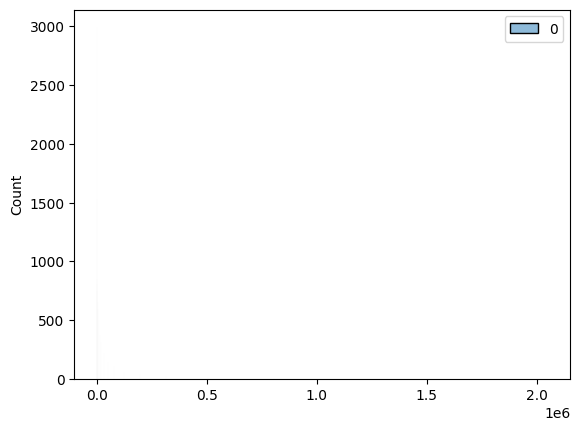

In [4]:
print(f"Loss counter: {loss_counter}")
print(df.describe())

# print(df.info())
sns.histplot(df)

plt.show()

## Reinforced Learning approach
Dynamic approach better than static, blah blah blah

In [5]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
import torch

In [6]:
import gymnasium as gym
from gymnasium import spaces


class InvestmentEnv(gym.Env):
    """
    Custom Gymnasium environment for the investment game.
    
    State Space:
        - Current capital (continuous)
        - Current round number (0-99)
    
    Action Space:
        - Investment percentage (continuous, 0.0 to 1.0)
    
    Rewards:
        - Based on capital change each round
    """
    
    def __init__(self, initial_capital=100, num_rounds=100, win_probability=0.6):
        super(InvestmentEnv, self).__init__()
        
        # Game parameters
        self.initial_capital = initial_capital
        self.num_rounds = num_rounds
        self.win_probability = win_probability
        
        # Define action space: investment percentage between 0% and 100%
        self.action_space = spaces.Box(
            low=0.0, 
            high=1.0, 
            shape=(1,), 
            dtype=np.float32
        )
        
        # Define observation space: [capital, round_number]
        # Capital can theoretically grow unbounded, but we'll set a reasonable upper limit
        self.observation_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float32),
            high=np.array([1, 1], dtype=np.float32),
            dtype=np.float32
        )
        
        # Initialise state
        self.capital = None
        self.current_round = None
        self.np_random = None
        
    def reset(self, seed=None, options=None):
        """
        Reset the environment to initial state.
        Called at the start of each episode.
        """
        super().reset(seed=seed)
        
        self.capital = float(self.initial_capital)
        self.current_round = 0
        
        observation = self._get_observation()
        info = {
            'capital': self.capital,
            'round': self.current_round
        }
        
        return observation, info
    
    def step(self, action):
        """Execute one round of the game."""
        old_capital = self.capital

        investment_percentage = np.clip(action[0], 0.0, 1.0)
        investment_amount = self.capital * investment_percentage

        outcome = self.np_random.random()

        if outcome < self.win_probability:
            self.capital += investment_amount
        else:
            self.capital -= investment_amount

        if self.capital < 0:
            self.capital = 0

        self.current_round += 1
        terminated = (self.current_round >= self.num_rounds) or (self.capital == 0)
        truncated = False

        # ========== PER-ROUND REWARD STRUCTURE ==========
        # 1. Base reward: Percentage growth (scaled up)
        if old_capital > 0:
            growth_pct = (self.capital - old_capital) / old_capital
            reward = growth_pct * 10  # Amplify to make it matter
        else:
            reward = 0

        # 2. Strong Kelly Criterion bonus
        kelly_optimal = 0.20
        kelly_distance = abs(investment_percentage - kelly_optimal)
        
        if kelly_distance < 0.05:  # 15-25% range
            reward += 0.5  # BIG bonus
        elif kelly_distance < 0.10:  # 10-30% range
            reward += 0.2

        # 3. Harsh penalty for being too conservative
        if investment_percentage < 0.05:
            reward -= 0.8  # Much stronger than before

        # 4. Harsh penalty for being too aggressive
        if investment_percentage > 0.5:
            reward -= 1.0

        # 5. Progress reward (small but adds up)
        reward += 0.03  # Incentivizes reaching later rounds


        if self.current_round < 20 and investment_percentage < 0.05:  # Too conservative (<5%)
            reward -= 0.3
        
        # 6. Terminal rewards
        if terminated:
            if self.capital > 0 and self.current_round == 100:
                growth_ratio = self.capital / self.initial_capital
                reward += np.log(growth_ratio) * 8 + 20
            elif self.capital == 0:
                # Heavy bankruptcy penalty
                rounds_survived_ratio = self.current_round / 100
                penalty = -25 * (1 - rounds_survived_ratio)  # Smaller penalty the further we go!
                reward += penalty

        observation = self._get_observation()
        info = {
            'capital': self.capital,
            'round': self.current_round,
            'investment_percentage': investment_percentage,
            'won': outcome < self.win_probability
        }

        return observation, reward, terminated, truncated, info
    
    def _get_observation(self):
        """Return normalized state observation."""
        # Log-normalize capital (handles exponential growth)
        normalized_capital = np.log(max(self.capital, 1)) / np.log(100000)  # Scale to ~[0, 1]
    
        # Normalize round to [0, 1]
        normalized_round = self.current_round / self.num_rounds
    
        return np.array([normalized_capital, normalized_round], dtype=np.float32)
    
    def render(self):
        """Optional: print current state (useful for debugging)."""
        print(f"Round {self.current_round}/{self.num_rounds} | Capital: ${self.capital:.2f}")

## Minimum Enviroment Test
Just to make sure it's working. Duh.

In [7]:
# Create environment
env = InvestmentEnv()

# Test one episode with random actions
observation, info = env.reset(seed=42)
print(f"Initial state: Capital=${observation[0]:.2f}, Round={observation[1]}")

for i in range(5):  # Just test 5 rounds
    # Random action (random investment percentage)
    action = env.action_space.sample()
    
    observation, reward, terminated, truncated, info = env.step(action)
    
    print(f"Round {info['round']}: Invested {info['investment_percentage']*100:.1f}% | "
          f"{'WON' if info['won'] else 'LOST'} | Capital: ${info['capital']:.2f}")
    
    if terminated:
        print("Episode ended!")
        break

env.close()

Initial state: Capital=$0.40, Round=0.0
Round 1: Invested 97.2% | LOST | Capital: $2.82
Round 2: Invested 49.3% | WON | Capital: $4.22
Round 3: Invested 96.8% | LOST | Capital: $0.14
Round 4: Invested 28.2% | LOST | Capital: $0.10
Round 5: Invested 10.9% | WON | Capital: $0.11


## RL Model Training

In [8]:
timestamp = datetime.now().strftime("%d-%m_%H-%M")
model_name = "n1_" + timestamp


# Create vectorised environment (runs multiple envs in parallel for faster training)
env = make_vec_env(InvestmentEnv, n_envs=32)

#! Turned off because reward normalisation "apparently" isn't necessary. Source: trust me bro.
# env = VecNormalize(
#     env,
#     norm_obs=False,  # We normalize in _get_observation already
#     norm_reward=True,  # Normalize rewards
#     clip_reward=10.0,
#     gamma=0.99
# )

# Create evaluation environment (for monitoring progress)
eval_env = make_vec_env(InvestmentEnv, n_envs=1)

#! Same as above
# eval_env = VecNormalize(
#     eval_env,
#     norm_obs=False,
#     norm_reward=True,  # Keep same settings as training
#     clip_reward=10.0,
#     gamma=0.99,
#     training=False  # Don't update stats during evaluation
# )


# Set up evaluation callback (checks performance during training)
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/',
    log_path='./logs/',
    eval_freq=10000,  # Evaluate every 10k steps
    deterministic=False,
    render=False,
    n_eval_episodes=100  # Run 100 episodes for evaluation
)

# Initialise PPO agent
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    clip_range=0.2,
    gamma=0.99,
    ent_coef=0.005, 
    device="cpu",
    tensorboard_log="./tensorboard/"
)

print("Starting training...")
print("=" * 50)

# Train the agent
model.learn(
    total_timesteps=2200000,  # Total training steps (adjust if needed)
    callback=eval_callback,
    progress_bar=True
)

# Save the trained model
model.save(f"models/{model_name}")
print(f"\nTraining complete! Model saved as '{model_name}'")

Using cpu device
Starting training...
Logging to ./tensorboard/PPO_54


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17       |
|    ep_rew_mean     | -19.8    |
| time/              |          |
|    fps             | 20199    |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 65536    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 18.2         |
|    ep_rew_mean          | -23          |
| time/                   |              |
|    fps                  | 3564         |
|    iterations           | 2            |
|    time_elapsed         | 36           |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0024584653 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | -0.000371    |
|    learning_rate        | 0.0003       |
|    loss                 | 151          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00216     |
|    std                  | 0.954        |
|    value_loss           | 273          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20.4        |
|    ep_rew_mean          | -19.6       |
| time/                   |             |
|    fps                  | 2801        |
|    iterations           | 3           |
|    time_elapsed         | 70          |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.001998104 |
|    clip_fraction        | 0.0121      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.0455      |
|    learning_rate        | 0.0003      |
|    loss                 | 84.5        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00105    |
|    std                  | 0.917       |
|    value_loss           | 213         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 17.6         |
|    ep_rew_mean          | -21.6        |
| time/                   |              |
|    fps                  | 2529         |
|    iterations           | 4            |
|    time_elapsed         | 103          |
|    total_timesteps      | 262144       |
| train/                  |              |
|    approx_kl            | 0.0022026328 |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.092        |
|    learning_rate        | 0.0003       |
|    loss                 | 140          |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00109     |
|    std                  | 0.895        |
|    value_loss           | 195          |
------------------------------------------


Eval num_timesteps=320000, episode_reward=-23.13 +/- 18.00

Episode length: 15.14 +/- 14.01

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 15.1         |
|    mean_reward          | -23.1        |
| time/                   |              |
|    total_timesteps      | 320000       |
| train/                  |              |
|    approx_kl            | 0.0025818252 |
|    clip_fraction        | 0.0199       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.093        |
|    learning_rate        | 0.0003       |
|    loss                 | 113          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00156     |
|    std                  | 0.867        |
|    value_loss           | 205          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.6     |
|    ep_rew_mean     | -21.5    |
| time/              |          |
|    fps             | 2368     |
|    iterations      | 5        |
|    time_elapsed    | 138      |
|    total_timesteps | 327680   |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 15.4         |
|    ep_rew_mean          | -21.3        |
| time/                   |              |
|    fps                  | 2314         |
|    iterations           | 6            |
|    time_elapsed         | 169          |
|    total_timesteps      | 393216       |
| train/                  |              |
|    approx_kl            | 0.0026423708 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.0675       |
|    learning_rate        | 0.0003       |
|    loss                 | 90.7         |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00144     |
|    std                  | 0.838        |
|    value_loss           | 222          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.5        |
|    ep_rew_mean          | -21.3       |
| time/                   |             |
|    fps                  | 2275        |
|    iterations           | 7           |
|    time_elapsed         | 201         |
|    total_timesteps      | 458752      |
| train/                  |             |
|    approx_kl            | 0.001975825 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0.0901      |
|    learning_rate        | 0.0003      |
|    loss                 | 97.1        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00119    |
|    std                  | 0.804       |
|    value_loss           | 227         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 18           |
|    ep_rew_mean          | -16.3        |
| time/                   |              |
|    fps                  | 2252         |
|    iterations           | 8            |
|    time_elapsed         | 232          |
|    total_timesteps      | 524288       |
| train/                  |              |
|    approx_kl            | 0.0023589046 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | 0.089        |
|    learning_rate        | 0.0003       |
|    loss                 | 131          |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00152     |
|    std                  | 0.764        |
|    value_loss           | 226          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 18.2         |
|    ep_rew_mean          | -17          |
| time/                   |              |
|    fps                  | 2209         |
|    iterations           | 9            |
|    time_elapsed         | 266          |
|    total_timesteps      | 589824       |
| train/                  |              |
|    approx_kl            | 0.0029326626 |
|    clip_fraction        | 0.0216       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 0.0856       |
|    learning_rate        | 0.0003       |
|    loss                 | 153          |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00158     |
|    std                  | 0.73         |
|    value_loss           | 243          |
------------------------------------------


Eval num_timesteps=640000, episode_reward=-18.55 +/- 24.10

Episode length: 17.61 +/- 14.04

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 17.6         |
|    mean_reward          | -18.6        |
| time/                   |              |
|    total_timesteps      | 640000       |
| train/                  |              |
|    approx_kl            | 0.0023505604 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.06        |
|    explained_variance   | 0.0748       |
|    learning_rate        | 0.0003       |
|    loss                 | 124          |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00128     |
|    std                  | 0.698        |
|    value_loss           | 242          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -20.1    |
| time/              |          |
|    fps             | 2173     |
|    iterations      | 10       |
|    time_elapsed    | 301      |
|    total_timesteps | 655360   |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 18           |
|    ep_rew_mean          | -20.4        |
| time/                   |              |
|    fps                  | 2148         |
|    iterations           | 11           |
|    time_elapsed         | 335          |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 0.0023549744 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.0706       |
|    learning_rate        | 0.0003       |
|    loss                 | 139          |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00172     |
|    std                  | 0.669        |
|    value_loss           | 244          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 22.4         |
|    ep_rew_mean          | -18          |
| time/                   |              |
|    fps                  | 2129         |
|    iterations           | 12           |
|    time_elapsed         | 369          |
|    total_timesteps      | 786432       |
| train/                  |              |
|    approx_kl            | 0.0030215965 |
|    clip_fraction        | 0.0241       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.97        |
|    explained_variance   | 0.0781       |
|    learning_rate        | 0.0003       |
|    loss                 | 190          |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00192     |
|    std                  | 0.637        |
|    value_loss           | 254          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 21           |
|    ep_rew_mean          | -17.4        |
| time/                   |              |
|    fps                  | 2113         |
|    iterations           | 13           |
|    time_elapsed         | 403          |
|    total_timesteps      | 851968       |
| train/                  |              |
|    approx_kl            | 0.0032536855 |
|    clip_fraction        | 0.0247       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.919       |
|    explained_variance   | 0.16         |
|    learning_rate        | 0.0003       |
|    loss                 | 117          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00208     |
|    std                  | 0.61         |
|    value_loss           | 256          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 16.8       |
|    ep_rew_mean          | -18.6      |
| time/                   |            |
|    fps                  | 2099       |
|    iterations           | 14         |
|    time_elapsed         | 436        |
|    total_timesteps      | 917504     |
| train/                  |            |
|    approx_kl            | 0.00232152 |
|    clip_fraction        | 0.0177     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.883     |
|    explained_variance   | 0.159      |
|    learning_rate        | 0.0003     |
|    loss                 | 175        |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.00154   |
|    std                  | 0.58       |
|    value_loss           | 276        |
----------------------------------------


Eval num_timesteps=960000, episode_reward=-14.00 +/- 34.79

Episode length: 23.56 +/- 24.70

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 23.6         |
|    mean_reward          | -14          |
| time/                   |              |
|    total_timesteps      | 960000       |
| train/                  |              |
|    approx_kl            | 0.0025169796 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.827       |
|    explained_variance   | 0.144        |
|    learning_rate        | 0.0003       |
|    loss                 | 168          |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.0021      |
|    std                  | 0.552        |
|    value_loss           | 286          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -9.81    |
| time/              |          |
|    fps             | 2083     |
|    iterations      | 15       |
|    time_elapsed    | 471      |
|    total_timesteps | 983040   |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 22.3       |
|    ep_rew_mean          | -14.7      |
| time/                   |            |
|    fps                  | 2071       |
|    iterations           | 16         |
|    time_elapsed         | 506        |
|    total_timesteps      | 1048576    |
| train/                  |            |
|    approx_kl            | 0.00239291 |
|    clip_fraction        | 0.0224     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.779     |
|    explained_variance   | 0.147      |
|    learning_rate        | 0.0003     |
|    loss                 | 132        |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.00205   |
|    std                  | 0.531      |
|    value_loss           | 281        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.2        |
|    ep_rew_mean          | -14.1       |
| time/                   |             |
|    fps                  | 2059        |
|    iterations           | 17          |
|    time_elapsed         | 540         |
|    total_timesteps      | 1114112     |
| train/                  |             |
|    approx_kl            | 0.003425864 |
|    clip_fraction        | 0.0285      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.734      |
|    explained_variance   | 0.197       |
|    learning_rate        | 0.0003      |
|    loss                 | 139         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00262    |
|    std                  | 0.5         |
|    value_loss           | 301         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 34.1         |
|    ep_rew_mean          | -4.34        |
| time/                   |              |
|    fps                  | 2050         |
|    iterations           | 18           |
|    time_elapsed         | 575          |
|    total_timesteps      | 1179648      |
| train/                  |              |
|    approx_kl            | 0.0028948907 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.677       |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 105          |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.0022      |
|    std                  | 0.475        |
|    value_loss           | 305          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30.5         |
|    ep_rew_mean          | -14.7        |
| time/                   |              |
|    fps                  | 2043         |
|    iterations           | 19           |
|    time_elapsed         | 609          |
|    total_timesteps      | 1245184      |
| train/                  |              |
|    approx_kl            | 0.0028439395 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.628       |
|    explained_variance   | 0.287        |
|    learning_rate        | 0.0003       |
|    loss                 | 170          |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.00245     |
|    std                  | 0.453        |
|    value_loss           | 306          |
------------------------------------------


Eval num_timesteps=1280000, episode_reward=-6.45 +/- 42.55

Episode length: 35.47 +/- 30.16

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 35.5         |
|    mean_reward          | -6.45        |
| time/                   |              |
|    total_timesteps      | 1280000      |
| train/                  |              |
|    approx_kl            | 0.0031310068 |
|    clip_fraction        | 0.0261       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.577       |
|    explained_variance   | 0.303        |
|    learning_rate        | 0.0003       |
|    loss                 | 136          |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00234     |
|    std                  | 0.431        |
|    value_loss           | 327          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.2     |
|    ep_rew_mean     | -8.2     |
| time/              |          |
|    fps             | 2033     |
|    iterations      | 20       |
|    time_elapsed    | 644      |
|    total_timesteps | 1310720  |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 41.2        |
|    ep_rew_mean          | -7.61       |
| time/                   |             |
|    fps                  | 2029        |
|    iterations           | 21          |
|    time_elapsed         | 678         |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.001955552 |
|    clip_fraction        | 0.0188      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.537      |
|    explained_variance   | 0.3         |
|    learning_rate        | 0.0003      |
|    loss                 | 133         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00177    |
|    std                  | 0.413       |
|    value_loss           | 341         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48           |
|    ep_rew_mean          | -6.45        |
| time/                   |              |
|    fps                  | 2024         |
|    iterations           | 22           |
|    time_elapsed         | 712          |
|    total_timesteps      | 1441792      |
| train/                  |              |
|    approx_kl            | 0.0026295357 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.489       |
|    explained_variance   | 0.314        |
|    learning_rate        | 0.0003       |
|    loss                 | 212          |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00237     |
|    std                  | 0.394        |
|    value_loss           | 347          |
------------------------------------------


Eval num_timesteps=1600000, episode_reward=9.45 +/- 58.14

Episode length: 58.19 +/- 33.90

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 58.2         |
|    mean_reward          | 9.45         |
| time/                   |              |
|    total_timesteps      | 1600000      |
| train/                  |              |
|    approx_kl            | 0.0024253428 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.357       |
|    explained_variance   | 0.386        |
|    learning_rate        | 0.0003       |
|    loss                 | 140          |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00188     |
|    std                  | 0.344        |
|    value_loss           | 364          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 54.1     |
|    ep_rew_mean     | 11.5     |
| time/              |          |
|    fps             | 2004     |
|    iterations      | 25       |
|    time_elapsed    | 817      |
|    total_timesteps | 1638400  |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63.1         |
|    ep_rew_mean          | 16.2         |
| time/                   |              |
|    fps                  | 2002         |
|    iterations           | 26           |
|    time_elapsed         | 851          |
|    total_timesteps      | 1703936      |
| train/                  |              |
|    approx_kl            | 0.0023625053 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.309       |
|    explained_variance   | 0.43         |
|    learning_rate        | 0.0003       |
|    loss                 | 220          |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00182     |
|    std                  | 0.329        |
|    value_loss           | 361          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 62.5         |
|    ep_rew_mean          | 8.44         |
| time/                   |              |
|    fps                  | 1999         |
|    iterations           | 27           |
|    time_elapsed         | 885          |
|    total_timesteps      | 1769472      |
| train/                  |              |
|    approx_kl            | 0.0022238926 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.269       |
|    explained_variance   | 0.425        |
|    learning_rate        | 0.0003       |
|    loss                 | 172          |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00144     |
|    std                  | 0.316        |
|    value_loss           | 384          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 68.7         |
|    ep_rew_mean          | 11.1         |
| time/                   |              |
|    fps                  | 1997         |
|    iterations           | 28           |
|    time_elapsed         | 918          |
|    total_timesteps      | 1835008      |
| train/                  |              |
|    approx_kl            | 0.0019425002 |
|    clip_fraction        | 0.0159       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.233       |
|    explained_variance   | 0.445        |
|    learning_rate        | 0.0003       |
|    loss                 | 169          |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.00137     |
|    std                  | 0.304        |
|    value_loss           | 387          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 74.8         |
|    ep_rew_mean          | 25.9         |
| time/                   |              |
|    fps                  | 1995         |
|    iterations           | 29           |
|    time_elapsed         | 952          |
|    total_timesteps      | 1900544      |
| train/                  |              |
|    approx_kl            | 0.0018318054 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 0.477        |
|    learning_rate        | 0.0003       |
|    loss                 | 171          |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.000945    |
|    std                  | 0.294        |
|    value_loss           | 387          |
------------------------------------------


Eval num_timesteps=1920000, episode_reward=24.03 +/- 71.62

Episode length: 75.50 +/- 33.12

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 75.5         |
|    mean_reward          | 24           |
| time/                   |              |
|    total_timesteps      | 1920000      |
| train/                  |              |
|    approx_kl            | 0.0021507647 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.157       |
|    explained_variance   | 0.477        |
|    learning_rate        | 0.0003       |
|    loss                 | 149          |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.0012      |
|    std                  | 0.284        |
|    value_loss           | 380          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 82.7     |
|    ep_rew_mean     | 19.3     |
| time/              |          |
|    fps             | 1988     |
|    iterations      | 30       |
|    time_elapsed    | 988      |
|    total_timesteps | 1966080  |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 80.5         |
|    ep_rew_mean          | 23.9         |
| time/                   |              |
|    fps                  | 1986         |
|    iterations           | 31           |
|    time_elapsed         | 1022         |
|    total_timesteps      | 2031616      |
| train/                  |              |
|    approx_kl            | 0.0021184967 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.123       |
|    explained_variance   | 0.5          |
|    learning_rate        | 0.0003       |
|    loss                 | 225          |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.000971    |
|    std                  | 0.273        |
|    value_loss           | 386          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 80.7         |
|    ep_rew_mean          | 15.2         |
| time/                   |              |
|    fps                  | 1984         |
|    iterations           | 32           |
|    time_elapsed         | 1056         |
|    total_timesteps      | 2097152      |
| train/                  |              |
|    approx_kl            | 0.0018389439 |
|    clip_fraction        | 0.0134       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0916      |
|    explained_variance   | 0.549        |
|    learning_rate        | 0.0003       |
|    loss                 | 206          |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.000641    |
|    std                  | 0.264        |
|    value_loss           | 393          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 85.7         |
|    ep_rew_mean          | 18.5         |
| time/                   |              |
|    fps                  | 1982         |
|    iterations           | 33           |
|    time_elapsed         | 1090         |
|    total_timesteps      | 2162688      |
| train/                  |              |
|    approx_kl            | 0.0012870389 |
|    clip_fraction        | 0.00734      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.072       |
|    explained_variance   | 0.581        |
|    learning_rate        | 0.0003       |
|    loss                 | 207          |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.000183    |
|    std                  | 0.259        |
|    value_loss           | 425          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 92.3         |
|    ep_rew_mean          | 29           |
| time/                   |              |
|    fps                  | 1981         |
|    iterations           | 34           |
|    time_elapsed         | 1124         |
|    total_timesteps      | 2228224      |
| train/                  |              |
|    approx_kl            | 0.0026493927 |
|    clip_fraction        | 0.0186       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0298      |
|    explained_variance   | 0.607        |
|    learning_rate        | 0.0003       |
|    loss                 | 201          |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00128     |
|    std                  | 0.249        |
|    value_loss           | 407          |
------------------------------------------



Training complete! Model saved as 'n1_18-12_09-51'


## RL Model Evaluation

In [9]:
# Load the trained model
model = PPO.load(f"models/{model_name}")

# Test the agent
def evaluate_agent(model, num_episodes=1000, seed=42):
    """
    Run the trained agent for multiple episodes and collect results.
    """
    env = InvestmentEnv()
    final_capitals = []
    bankruptcies = 0
    
    for episode in range(num_episodes):
        obs, info = env.reset(seed=seed + episode)
        episode_capital = []
        
        terminated = False
        while not terminated:
            # Agent chooses action
            action, _states = model.predict(obs, deterministic=False)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_capital.append(info['capital'])
        
        final_capital = info['capital']
        final_capitals.append(final_capital)
        
        if final_capital == 0:
            bankruptcies += 1
    
    return np.array(final_capitals), bankruptcies


# Run evaluation
print("Evaluating trained agent...")
rl_capitals, rl_bankruptcies = evaluate_agent(model, num_episodes=1000)

print("\n" + "=" * 50)
print("RL AGENT PERFORMANCE (1,000 episodes)")
print("=" * 50)
print(f"Mean final capital: ${rl_capitals.mean():,.2f}")
print(f"Median final capital: ${np.median(rl_capitals):,.2f}")
print(f"Std deviation: ${rl_capitals.std():,.2f}")
print(f"Min: ${rl_capitals.min():,.2f}")
print(f"Max: ${rl_capitals.max():,.2f}")
print(f"Bankruptcies: {rl_bankruptcies} ({rl_bankruptcies/10:.1f}%)")
print("=" * 50)

a:\Repositories\Investing-simulation\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Evaluating trained agent...

RL AGENT PERFORMANCE (1,000 episodes)
Mean final capital: $19,888.43
Median final capital: $5.10
Std deviation: $257,619.52
Min: $0.00
Max: $5,964,348.50
Bankruptcies: 160 (16.0%)


In [10]:
#! DEBUGGING

def debug_agent_actions(model, num_episodes=10):
    env = InvestmentEnv()
    all_actions = []
    
    for episode in range(num_episodes):
        obs, info = env.reset(seed=42 + episode)
        
        terminated = False
        episode_actions = []
        while not terminated:
            action, _states = model.predict(obs, deterministic=False)
            episode_actions.append(action[0] * 100)  # Convert to percentage
            obs, reward, terminated, truncated, info = env.step(action)
        
        all_actions.extend(episode_actions)
    
    print(f"Average investment %: {np.mean(all_actions):.2f}%")
    print(f"Min investment %: {np.min(all_actions):.2f}%")
    print(f"Max investment %: {np.max(all_actions):.2f}%")
    
debug_agent_actions(model, num_episodes=100)

Average investment %: 34.26%
Min investment %: 0.00%
Max investment %: 100.00%


## Static vs Dynamic Strategy Comparison

In [11]:
def evaluate_fixed_strategy(percentage, num_episodes=10000, seed=42):
    """
    Test a fixed investment percentage strategy.
    """
    env = InvestmentEnv()
    final_capitals = []
    bankruptcies = 0
    
    for episode in range(num_episodes):
        obs, info = env.reset(seed=seed + episode)
        
        terminated = False
        while not terminated:
            action = np.array([percentage])  # Fixed percentage
            obs, reward, terminated, truncated, info = env.step(action)
        
        final_capital = info['capital']
        final_capitals.append(final_capital)
        
        if final_capital == 0:
            bankruptcies += 1
    
    return np.array(final_capitals), bankruptcies


# Test fixed 20% strategy
print("\nEvaluating fixed 20% strategy...")
fixed_capitals, fixed_bankruptcies = evaluate_fixed_strategy(0.20, num_episodes=10000)

print("\n" + "=" * 50)
print("FIXED 20% STRATEGY PERFORMANCE (10,000 episodes)")
print("=" * 50)
print(f"Mean final capital: ${fixed_capitals.mean():,.2f}")
print(f"Median final capital: ${np.median(fixed_capitals):,.2f}")
print(f"Std deviation: ${fixed_capitals.std():,.2f}")
print(f"Min: ${fixed_capitals.min():,.2f}")
print(f"Max: ${fixed_capitals.max():,.2f}")
print(f"Bankruptcies: {fixed_bankruptcies} ({fixed_bankruptcies/100:.1f}%)")
print("=" * 50)

# Compare
print("\n" + "=" * 50)
print("COMPARISON")
print("=" * 50)
print(f"RL Agent median: ${np.median(rl_capitals):,.2f}")
print(f"Fixed 20% median: ${np.median(fixed_capitals):,.2f}")
print(f"Improvement: {((np.median(rl_capitals) / np.median(fixed_capitals)) - 1) * 100:.1f}%")
print("=" * 50)


Evaluating fixed 20% strategy...

FIXED 20% STRATEGY PERFORMANCE (10,000 episodes)
Mean final capital: $5,223.36
Median final capital: $748.99
Std deviation: $26,581.68
Min: $0.23
Max: $1,660,382.57
Bankruptcies: 0 (0.0%)

COMPARISON
RL Agent median: $5.10
Fixed 20% median: $748.99
Improvement: -99.3%


## Visualisations

C:\Users\davia\AppData\Local\Temp\ipykernel_12480\1526878158.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_box.boxplot(box_data, labels=['Deterministic', 'Stochastic'],


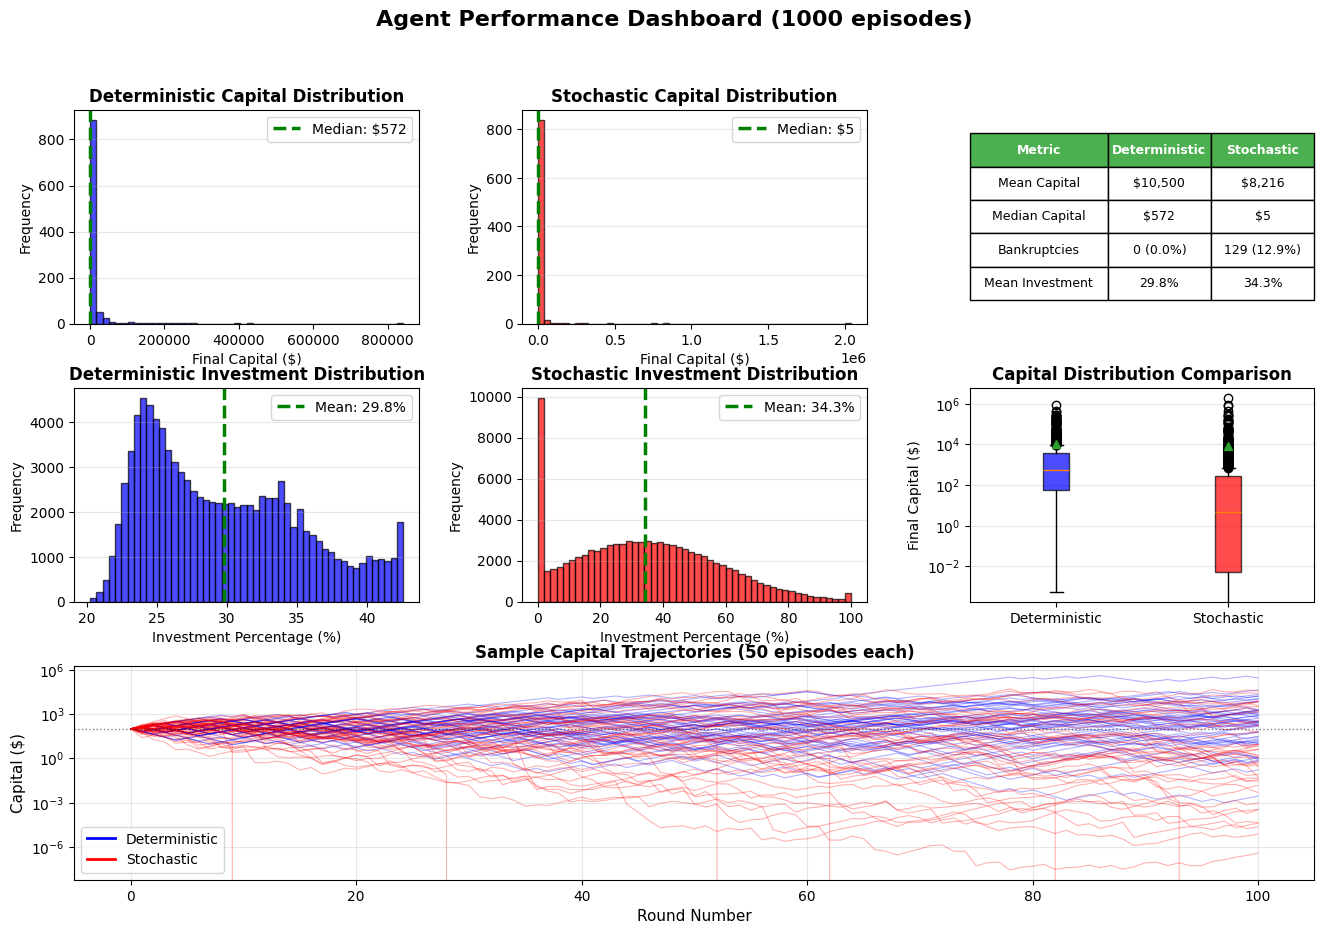

In [12]:
# ============================================================================
# 2: Quick Performance Dashboard
# ============================================================================
def performance_dashboard(model, num_test_episodes=1000):
    """
    Quick performance dashboard comparing deterministic vs stochastic evaluation.
    """
    env = InvestmentEnv()
    
    # Test with both modes
    results = {}
    
    for mode_name, deterministic in [('Deterministic', True), ('Stochastic', False)]:
        capitals = []
        investments = []
        bankruptcies = 0
        
        for episode in range(num_test_episodes):
            obs, info = env.reset(seed=42 + episode)
            episode_investments = []
            
            terminated = False
            while not terminated:
                action, _states = model.predict(obs, deterministic=deterministic)
                episode_investments.append(action[0] * 100)
                obs, reward, terminated, truncated, info = env.step(action)
            
            capitals.append(info['capital'])
            investments.extend(episode_investments)
            if info['capital'] == 0:
                bankruptcies += 1
        
        results[mode_name] = {
            'capitals': np.array(capitals),
            'investments': np.array(investments),
            'bankruptcies': bankruptcies
        }
    
    # Create dashboard
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Title
    fig.suptitle(f'Agent Performance Dashboard ({num_test_episodes} episodes)', 
                fontsize=16, fontweight='bold')
    
    # Row 1: Capital distributions
    for idx, (mode_name, colour) in enumerate([('Deterministic', 'blue'), ('Stochastic', 'red')]):
        ax = fig.add_subplot(gs[0, idx])
        data = results[mode_name]['capitals']
        ax.hist(data[data > 0], bins=50, color=colour, alpha=0.7, edgecolor='black')
        ax.axvline(np.median(data), color='green', linestyle='--', 
                  linewidth=2.5, label=f'Median: ${np.median(data):,.0f}')
        ax.set_xlabel('Final Capital ($)', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_title(f'{mode_name} Capital Distribution', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    # Summary statistics table
    ax_table = fig.add_subplot(gs[0, 2])
    ax_table.axis('off')
    
    table_data = []
    table_data.append(['Metric', 'Deterministic', 'Stochastic'])
    table_data.append(['Mean Capital', 
                      f'${results["Deterministic"]["capitals"].mean():,.0f}',
                      f'${results["Stochastic"]["capitals"].mean():,.0f}'])
    table_data.append(['Median Capital', 
                      f'${np.median(results["Deterministic"]["capitals"]):,.0f}',
                      f'${np.median(results["Stochastic"]["capitals"]):,.0f}'])
    table_data.append(['Bankruptcies', 
                      f'{results["Deterministic"]["bankruptcies"]} ({results["Deterministic"]["bankruptcies"]/num_test_episodes*100:.1f}%)',
                      f'{results["Stochastic"]["bankruptcies"]} ({results["Stochastic"]["bankruptcies"]/num_test_episodes*100:.1f}%)'])
    table_data.append(['Mean Investment', 
                      f'{results["Deterministic"]["investments"].mean():.1f}%',
                      f'{results["Stochastic"]["investments"].mean():.1f}%'])
    
    table = ax_table.table(cellText=table_data, cellLoc='center', loc='center',
                          colWidths=[0.4, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header row
    for i in range(3):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Row 2: Investment distributions
    for idx, (mode_name, colour) in enumerate([('Deterministic', 'blue'), ('Stochastic', 'red')]):
        ax = fig.add_subplot(gs[1, idx])
        data = results[mode_name]['investments']
        ax.hist(data, bins=50, color=colour, alpha=0.7, edgecolor='black')
        ax.axvline(data.mean(), color='green', linestyle='--', 
                  linewidth=2.5, label=f'Mean: {data.mean():.1f}%')
        ax.set_xlabel('Investment Percentage (%)', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_title(f'{mode_name} Investment Distribution', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    # Box plot comparison
    ax_box = fig.add_subplot(gs[1, 2])
    box_data = [results['Deterministic']['capitals'], results['Stochastic']['capitals']]
    bp = ax_box.boxplot(box_data, labels=['Deterministic', 'Stochastic'],
                        patch_artist=True, showmeans=True)
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][1].set_facecolor('red')
    for box in bp['boxes']:
        box.set_alpha(0.7)
    ax_box.set_ylabel('Final Capital ($)', fontsize=10)
    ax_box.set_title('Capital Distribution Comparison', fontsize=12, fontweight='bold')
    ax_box.grid(True, alpha=0.3, axis='y')
    ax_box.set_yscale('log')
    
    # Row 3: Capital growth over episodes (sample)
    ax_growth = fig.add_subplot(gs[2, :])
    
    # Sample 50 episodes for visualization
    sample_episodes = 50
    for mode_name, colour, alpha in [('Deterministic', 'blue', 0.3), ('Stochastic', 'red', 0.3)]:
        deterministic = (mode_name == 'Deterministic')
        
        for episode_idx in range(sample_episodes):
            obs, info = env.reset(seed=1000 + episode_idx)
            capital_history = [100]
            
            terminated = False
            while not terminated:
                action, _states = model.predict(obs, deterministic=deterministic)
                obs, reward, terminated, truncated, info = env.step(action)
                capital_history.append(info['capital'])
            
            ax_growth.plot(range(len(capital_history)), capital_history, 
                          color=colour, alpha=alpha, linewidth=0.8)
    
    ax_growth.set_xlabel('Round Number', fontsize=11)
    ax_growth.set_ylabel('Capital ($)', fontsize=11)
    ax_growth.set_title(f'Sample Capital Trajectories ({sample_episodes} episodes each)', 
                       fontsize=12, fontweight='bold')
    ax_growth.set_yscale('log')
    ax_growth.grid(True, alpha=0.3)
    ax_growth.axhline(y=100, color='black', linestyle=':', linewidth=1, alpha=0.5)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Deterministic'),
                      Line2D([0], [0], color='red', lw=2, label='Stochastic')]
    ax_growth.legend(handles=legend_elements, loc='best')
    
    plt.savefig(f"plots/agentperf{model_name}")
    plt.show()


# Run the dashboard
performance_dashboard(model, num_test_episodes=1000)

In [13]:
def analyse_agent_strategy_fixed(model, num_episodes=500):
    """
    Comprehensive strategy analysis with proper denormalization and all 6 plots.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    env = InvestmentEnv()
    
    # Collect data for both deterministic and stochastic
    results = {}
    
    for mode_name, deterministic in [('Deterministic', True), ('Stochastic', False)]:
        investment_data = {round_num: [] for round_num in range(100)}
        capital_data = {round_num: [] for round_num in range(100)}
        
        final_capitals = []
        episodes_completed = 0
        episodes_bankrupted = 0
        
        # Track capital trajectories for evolution plot
        capital_trajectories = []
        
        for episode in range(num_episodes):
            obs, info = env.reset(seed=42 + episode)
            
            episode_trajectory = [info['capital']]  # Start with initial capital
            
            terminated = False
            while not terminated:
                action, _states = model.predict(obs, deterministic=deterministic)
                
                # Use info dict for actual values (not normalized observations)
                current_round = info['round']  # This is already 0-99
                current_capital = info['capital']  # Already actual capital
                investment_pct = action[0]
                
                investment_data[current_round].append(investment_pct * 100)
                capital_data[current_round].append(current_capital)
                
                obs, reward, terminated, truncated, info = env.step(action)
                episode_trajectory.append(info['capital'])
            
            final_capitals.append(info['capital'])
            capital_trajectories.append(episode_trajectory)
            
            if info['capital'] > 0:
                episodes_completed += 1
            else:
                episodes_bankrupted += 1
        
        # Calculate statistics per round
        rounds = []
        mean_investments = []
        std_investments = []
        mean_capitals = []
        
        for round_num in range(100):
            if investment_data[round_num]:
                rounds.append(round_num)
                mean_investments.append(np.mean(investment_data[round_num]))
                std_investments.append(np.std(investment_data[round_num]))
                mean_capitals.append(np.mean(capital_data[round_num]))
        
        results[mode_name] = {
            'rounds': rounds,
            'mean_investments': mean_investments,
            'std_investments': std_investments,
            'mean_capitals': mean_capitals,
            'final_capitals': np.array(final_capitals),
            'episodes_completed': episodes_completed,
            'episodes_bankrupted': episodes_bankrupted,
            'capital_trajectories': capital_trajectories
        }
    
    # ========== CREATE 6-PANEL PLOT ==========
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    fig.suptitle('RL Agent Strategy Analysis', fontsize=18, fontweight='bold')
    
    # ===== ROW 1: Investment Strategies =====
    
    # Plot 1: Stochastic Investment Strategy
    ax1 = fig.add_subplot(gs[0, 0])
    stoch = results['Stochastic']
    ax1.plot(stoch['rounds'], stoch['mean_investments'], linewidth=2.5, color='blue', 
            label='Mean Investment')
    ax1.fill_between(stoch['rounds'],
                     np.array(stoch['mean_investments']) - np.array(stoch['std_investments']),
                     np.array(stoch['mean_investments']) + np.array(stoch['std_investments']),
                     alpha=0.3, color='blue', label='±1 std')
    ax1.axhline(y=20, color='red', linestyle='--', linewidth=2, label='Fixed 20%', alpha=0.7)
    ax1.set_xlabel('Round Number', fontsize=11)
    ax1.set_ylabel('Investment Percentage (%)', fontsize=11)
    ax1.set_title(f'Investment Strategy (Stochastic)\n'
                 f'{stoch["episodes_completed"]} completed, {stoch["episodes_bankrupted"]} bankrupted', 
                 fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9)
    ax1.set_ylim(bottom=0)
    ax1.set_xlim([0, 100])  # Fixed range
    
    # Plot 2: Deterministic Investment Strategy
    ax2 = fig.add_subplot(gs[0, 1])
    det = results['Deterministic']
    ax2.plot(det['rounds'], det['mean_investments'], linewidth=2.5, color='green', 
            label='Mean Investment')
    ax2.axhline(y=20, color='red', linestyle='--', linewidth=2, label='Fixed 20%', alpha=0.7)
    ax2.set_xlabel('Round Number', fontsize=11)
    ax2.set_ylabel('Investment Percentage (%)', fontsize=11)
    ax2.set_title(f'Investment Strategy (Deterministic)\n'
                 f'{det["episodes_completed"]} completed, {det["episodes_bankrupted"]} bankrupted', 
                 fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=9)
    ax2.set_ylim(bottom=0)
    ax2.set_xlim([0, 100])  # Fixed range
    
    # ===== ROW 2: Capital Evolution =====
    
    # Plot 3: Stochastic Capital Evolution
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(stoch['rounds'], stoch['mean_capitals'], linewidth=2.5, color='purple', 
            label='Mean Capital')
    ax3.axhline(y=100, color='gray', linestyle=':', linewidth=1.5, 
               label='Starting Capital', alpha=0.7)
    ax3.set_xlabel('Round Number', fontsize=11)
    ax3.set_ylabel('Capital ($)', fontsize=11)
    ax3.set_title('Capital Evolution (Stochastic)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)
    ax3.set_yscale('log')
    ax3.set_xlim([0, 100])  # Fixed range
    
    # Plot 4: Deterministic Capital Evolution
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(det['rounds'], det['mean_capitals'], linewidth=2.5, color='orange', 
            label='Mean Capital')
    ax4.axhline(y=100, color='gray', linestyle=':', linewidth=1.5, 
               label='Starting Capital', alpha=0.7)
    ax4.set_xlabel('Round Number', fontsize=11)
    ax4.set_ylabel('Capital ($)', fontsize=11)
    ax4.set_title('Capital Evolution (Deterministic)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=9)
    ax4.set_yscale('log')
    ax4.set_xlim([0, 100])  # Fixed range
    
    # ===== ROW 3: Final Capital Distributions =====
    
    # Plot 5: Stochastic Final Capital Distribution
    ax5 = fig.add_subplot(gs[2, 0])
    stoch_caps = stoch['final_capitals']
    stoch_caps_nonzero = stoch_caps[stoch_caps > 0]
    
    if len(stoch_caps_nonzero) > 0:
        # Use log bins for better visualization
        bins = np.logspace(np.log10(max(stoch_caps_nonzero.min(), 0.01)), 
                          np.log10(stoch_caps_nonzero.max()), 40)
        counts, _ = np.histogram(stoch_caps_nonzero, bins=bins)
        # Normalize to percentages
        counts_normalized = counts / len(stoch_caps) * 100
        ax5.bar(bins[:-1], counts_normalized, width=np.diff(bins), 
               align='edge', color='red', alpha=0.7, edgecolor='black')
    
    median_val = np.median(stoch_caps)
    ax5.axvline(median_val if median_val > 0 else 0.01, color='green', linestyle='--', 
               linewidth=2.5, label=f'Median: ${median_val:,.0f}')
    ax5.set_xlabel('Final Capital ($)', fontsize=11)
    ax5.set_ylabel('Frequency (%)', fontsize=11)
    ax5.set_title('Final Capital Distribution (Stochastic)', fontsize=12, fontweight='bold')
    ax5.set_xscale('log')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Deterministic Final Capital Distribution  
    ax6 = fig.add_subplot(gs[2, 1])
    det_caps = det['final_capitals']
    det_caps_nonzero = det_caps[det_caps > 0]
    
    if len(det_caps_nonzero) > 0:
        # Use log bins
        bins = np.logspace(np.log10(max(det_caps_nonzero.min(), 0.01)), 
                          np.log10(det_caps_nonzero.max()), 40)
        counts, _ = np.histogram(det_caps_nonzero, bins=bins)
        # Normalize to percentages
        counts_normalized = counts / len(det_caps) * 100
        ax6.bar(bins[:-1], counts_normalized, width=np.diff(bins), 
               align='edge', color='blue', alpha=0.7, edgecolor='black')
    
    median_val = np.median(det_caps)
    ax6.axvline(median_val, color='green', linestyle='--', 
               linewidth=2.5, label=f'Median: ${median_val:,.0f}')
    ax6.set_xlabel('Final Capital ($)', fontsize=11)
    ax6.set_ylabel('Frequency (%)', fontsize=11)
    ax6.set_title('Final Capital Distribution (Deterministic)', fontsize=12, fontweight='bold')
    ax6.set_xscale('log')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("STRATEGY ANALYSIS SUMMARY")
    print("="*80)
    for mode_name in ['Stochastic', 'Deterministic']:
        r = results[mode_name]
        caps = r['final_capitals']
        print(f"\n{mode_name.upper()}:")
        print(f"  Episodes analysed: {num_episodes}")
        print(f"  Completed (round 100): {r['episodes_completed']} ({r['episodes_completed']/num_episodes*100:.1f}%)")
        print(f"  Bankrupted: {r['episodes_bankrupted']} ({r['episodes_bankrupted']/num_episodes*100:.1f}%)")
        print(f"  Mean investment: {np.mean(r['mean_investments']):.2f}%")
        print(f"  Mean final capital: ${caps.mean():,.2f}")
        print(f"  Median final capital: ${np.median(caps):,.2f}")
        print(f"  Capital range: ${caps.min():,.2f} - ${caps.max():,.2f}")
    print("="*80)


# ========== ALTERNATIVE: Comparison on same plot ==========
def capital_evolution_comparison(model, num_episodes=100):
    """
    Side-by-side capital evolution comparison.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    env = InvestmentEnv()
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    
    for mode_name, deterministic, colour in [('Deterministic', True, 'blue'), 
                                             ('Stochastic', False, 'red')]:
        capital_data = {round_num: [] for round_num in range(100)}
        
        for episode in range(num_episodes):
            obs, info = env.reset(seed=42 + episode)
            
            terminated = False
            while not terminated:
                action, _states = model.predict(obs, deterministic=deterministic)
                current_round = info['round']
                current_capital = info['capital']
                
                capital_data[current_round].append(current_capital)
                
                obs, reward, terminated, truncated, info = env.step(action)
        
        # Calculate mean per round
        rounds = []
        mean_capitals = []
        
        for round_num in range(100):
            if capital_data[round_num]:
                rounds.append(round_num)
                mean_capitals.append(np.mean(capital_data[round_num]))
        
        ax.plot(rounds, mean_capitals, linewidth=3, color=colour, 
               label=f'{mode_name}', alpha=0.8)
    
    ax.axhline(y=100, color='gray', linestyle=':', linewidth=2, 
              label='Starting Capital', alpha=0.7)
    ax.axhline(y=700, color='green', linestyle='--', linewidth=2, 
              label='Fixed 20% Expected (~$700)', alpha=0.7)
    ax.set_xlabel('Round Number', fontsize=13)
    ax.set_ylabel('Mean Capital ($)', fontsize=13)
    ax.set_title('Capital Evolution: Stochastic vs Deterministic', 
                fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_yscale('log')
    ax.set_xlim([0, 100])
    
    plt.tight_layout()
    plt.show()

C:\Users\davia\AppData\Local\Temp\ipykernel_12480\1485141296.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


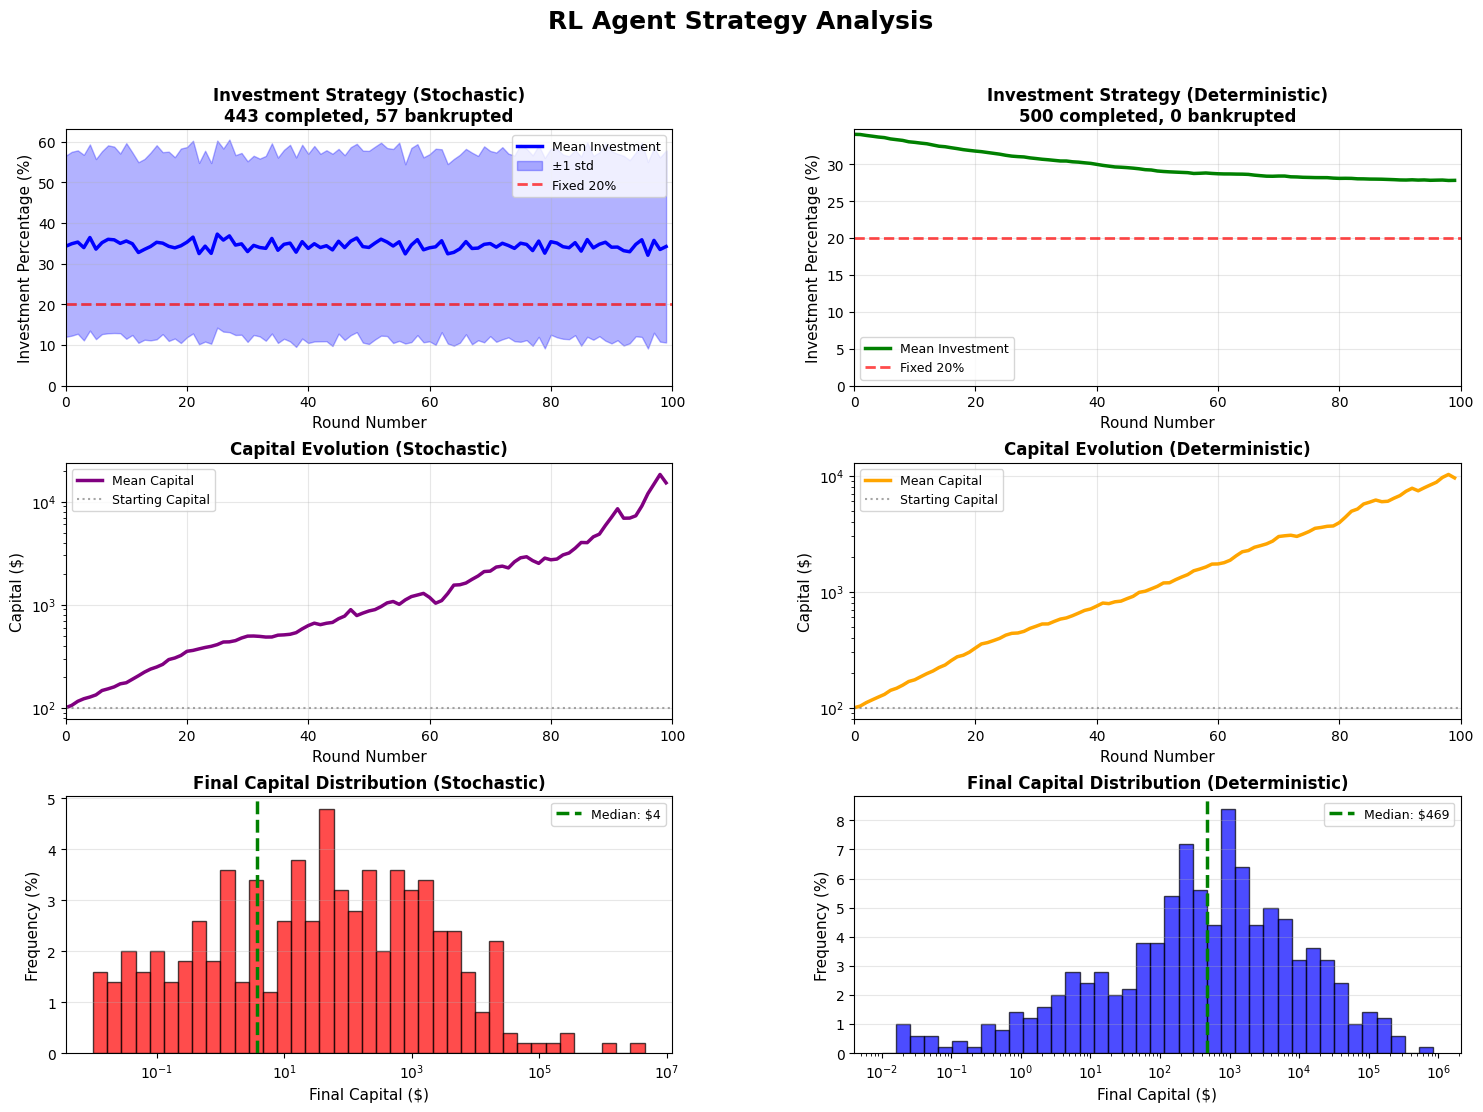


STRATEGY ANALYSIS SUMMARY

STOCHASTIC:
  Episodes analysed: 500
  Completed (round 100): 443 (88.6%)
  Bankrupted: 57 (11.4%)
  Mean investment: 34.52%
  Mean final capital: $13,912.09
  Median final capital: $3.68
  Capital range: $0.00 - $4,478,607.50

DETERMINISTIC:
  Episodes analysed: 500
  Completed (round 100): 500 (100.0%)
  Bankrupted: 0 (0.0%)
  Mean investment: 29.89%
  Mean final capital: $10,647.41
  Median final capital: $468.66
  Capital range: $0.00 - $841,351.69


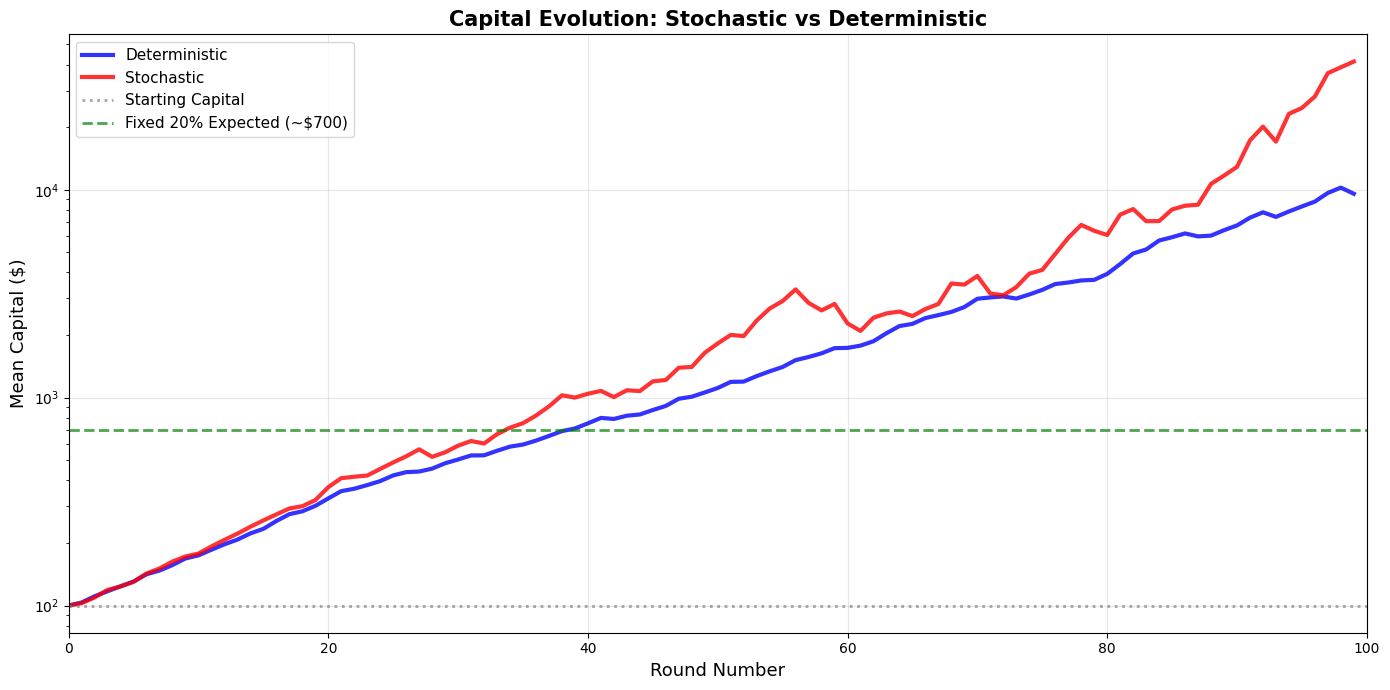

In [14]:
analyse_agent_strategy_fixed(model, num_episodes=500)
capital_evolution_comparison(model, num_episodes=500)